# Astrostats Week 12: Dimension Reduction 


## Dimensionality and the "Curse of Dimensionality"

Key points from the lecture:
- Each of the “things” we can measure about an object is a “dimension” or “feature” of that object
- We need D pieces of information (dimensions) to describe the location of each object in a D-dimensional space
- The intrinsic dimension of a space is the minimum number of dimensions you need to describe a location in that space 
- The extrinsic dimension of a space is the number of dimensions you actually measure

- The more dimensions a dataset has, the more data is required to constrain a model

### Exercise: Investiage the "Curse of Dimensionality"

Generate $n$ random points in $D$-dimensions and count how many of those points fall within a $D$-dimensional hypersphere of radius $1$ centered on the  origin.  
When generating the random points, restrict them to some reasonable range such as $[-2,2]$ in each dimension. 

How does the number of points within the hypersphere scale with dimension? Plot counts vs dimensions. 



<details>
  <summary>Hint 1:</summary>
For example:   
    
    - in the 2-D case generate n random points (x,y) and count how many points fall within a circle centered on the origin.  
    - in the 3-D case generate n random points (x,y,z) and count how many points fall within a sphere centered on the origin.  
Extrapolate this for higher dimensions. 
</details>
  

<details>
  <summary>Hint 2:</summary>
Points fall within the hypersphere of radius $1$ if their Euclidean distance from the origin is less than or equal to 1. 
</details>

<details>
  <summary>Hint 3:</summary>
The D-dimensionsal Euclidean distance to the origin is given by:
\begin{equation}
d = \sqrt{ \sum_{i=0}^{D} ( x_i )^2 }
\end{equation}
Check if this distance is less than one for each point. 
</details>

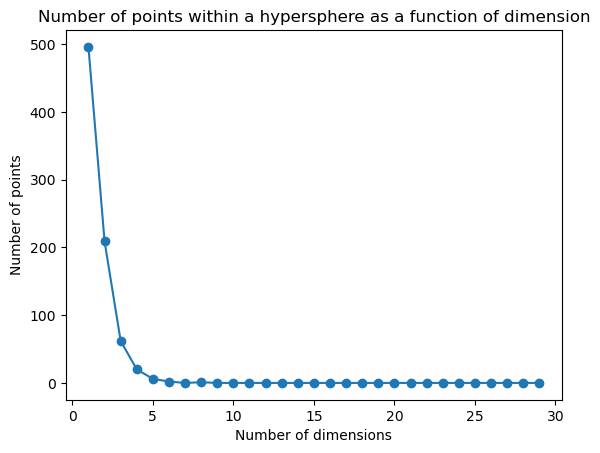

In [7]:
import matplotlib.pyplot as plt
import numpy as np


def countPointsinHyperSphere( D, n = int(1e3) ): 
    '''
    Count the number of randomly generated points which fall inside a D-dimensional hypersphere

    Inputs:
    D = number of dimensions 
    n = number of points

    Returns:
    cnt = number of points which fell inside the D-dimensional hypersphere
    '''
    ### YOUR CODE HERE ###
    
    cnt = 0
    
    for point in range(0, n):
        
        # Generate a random point in the range [-2, 2] along each axis 
        point = np.random.random( D ) * 4 - 2
    
        # Calculate the distance to the origin
        dist = np.sqrt( np.sum(point**2) )
    
        # If distance is less than 1, update the count 
        if dist <= 1:
            cnt += 1

    return cnt


dims = np.arange(1,30)
cnt = [ countPointsinHyperSphere( val ) for val in dims ]


plt.figure()
plt.title('Number of points within a hypersphere as a function of dimension')
plt.xlabel('Number of dimensions')
plt.ylabel('Number of points')

plt.plot( dims, cnt, '-o' ) 

## Dimensionality and the "Curse of Dimensionality"



We will now build our own function for PCA and use it to work with SDSS galaxy spectra data


### Exercise: Build and play with PCA

In [ ]:
'''First, let`s install python module to get SDSS data'''
!pip install astroML

from astroML.datasets import sdss_corrected_spectra

In [ ]:
'''Let`s now fetch spectra of 4000 galaxies that span across 1000 wavelength '''

data = sdss_corrected_spectra.fetch_sdss_corrected_spectra() # data dictionary
spectra = sdss_corrected_spectra.reconstruct_spectra(data) # [4000, 1000] data
wavelength = sdss_corrected_spectra.compute_wavelengths(data) # wavelength for spectra
cl = data['spec_cln'] # spectral class (yes, not everything is galaxy spectra here)

Now when we have our data, before we run PCA on it, we have to rescale it. 
If our data had features of different units, we should standardize features by removing the mean and scaling to unit variance (see [StandardScaler - scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)). 
But we only have flux at different wavelength, so we can just remove the mean spectra.


In [ ]:
avg_spectra = np.average(spectra, axis=0)
rescaled_data = spectra - avg_spectra

Use singular value decomposition (SVD) to write function for PCA that will take our data and output eigenvectors, eigenvalues and projection of our data on principal components. Fortunately, numpy has SVD ([numpy.linalg.svd - NumPy](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html)).

Then build a Scree plot that can tell us how many principal components are enought to characterize majority of variane in our data.

In [ ]:
def PCA(rescaled_data):
    '''
    Principal Components Analysis

    Parameters
    ----------
    rescaled_data : Array [M, F]
        M - number of samples of data. F - number of features.
        In your case it`s [galaxies, wavelengthes]

    Returns
    -------
    ei_vals : Array [min(M, F),]
        Eigenvalues which define the amount of variance contained within each component.
    ei_vecs : Array [min(M, F), min(M, F)]
        Eigenvectors (principal components) - vectors that are aligned with the deriction of maximal variance.
    projected : Array [M, min(M, F)]
        Data projected on eigenvectors.

    '''
    
    U, Sigma, VT = np.linalg.svd(rescaled_data, full_matrices=False)
    ei_vals = Sigma**2
    ei_vecs = VT
    projected = np.dot(rescaled_data, VT[:, :] )
    
    return ei_vals, ei_vecs, projected

In [ ]:
ei_vals, ei_vecs, projected = PCA(rescaled)

total_variance = np.sum(ei_vals)
variance_ratio = ei_vals / total_variance
cumulative_variance_ratio = np.cumsum(variance_ratio)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ei_vals) + 1), variance_ratio, alpha=0.7, align='center', label='Individual explained variance')
plt.step(range(1, len(ei_vals) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
# plt.title('Scree Plot')
plt.xscale('log')
plt.xlim(1,1000)
plt.legend()
plt.grid(True)
plt.show()

It is often usefull in the analysis to plot Principal Component Plane (PCP). It's even better when the data can be mostly described by 2 Principal Components, which is our case. Make a scatter plot using any 2 projected data vectors.

In [ ]:
PC_index_1 = 0
PC_index_2 = 1

plt.scatter(projected[:,PC_index_1], 
            projected[:,PC_index_2], s=1, zorder=1)
plt.show()


PCP can help to identify outliers, extreme data cases and cluster the data. Our spectra is not completely consists of galaxies. Add these lines to your plot and see where non-galactic spectra lies on PCP:

In [ ]:
plt.scatter(projected[:,PC_index_1][unknown_mask], 
            projected[:,PC_index_2][unknown_mask], s=1, c='black',zorder=10)
plt.scatter(projected[:,PC_index_1][quasar_mask], 
            projected[:,PC_index_2][quasar_mask], s=1, c='orange',zorder=10)
plt.scatter(projected[:,PC_index_1][redstar_mask], 
            projected[:,PC_index_2][redstar_mask], s=1, c='red',zorder=10)
plt.scatter(projected[:,PC_index_1][star_mask], 
            projected[:,PC_index_2][star_mask], s=1, c='purple',zorder=10)

plt.scatter(projected[:,PC_index_1], 
            projected[:,PC_index_2], s=1, zorder=1)
plt.show()

We can reconstruct data points from PC-projection back to real data. This is used to see how outliers look, explore extreme cases or reduce noise of the data.

Build a function to deproject data from PC hyperplane, rescale and retrieved real data. It is easy to see that zero-vector on PC hyperplane will be qeual to the mean after deprojection. Try it for yourself. If deprojected zero-vector is = to mean spectra, this means your PCA is correct. You can then deproject different coordinates or whole data and see what it looks like.

In [ ]:
def reconstruct(PC_coords, eigenvectors, mean):
    '''
    Reconstructs data from projection coordinates.

    Parameters
    ----------
    PCP_coords : Array [M , K]
        Coodinates in PC hyperplane.
        M is number of measurements, K is number of principal components.
        Example: if you want to reconstruct single point on 2D PCP, 
        your PCP_coords are gonna be [[x, y]].
    eigenvectors : Array [K , F]
        Eigenvector array of your PCA.
        K is number of principal components. F is number of features, in your case –
        number of wavelength.
    mean : array [M,]
        Array of average values of your raw data. In your case – average spectra

    Returns
    -------
    reconstructed : Array [M x F]
        Returns ([M , K] ⋅ [K , F]) + [F,] – data reconstructed from K 
        principal components

    '''
    
    
    reconstructed = np.dot(PC_coords, eigenvectors[:n_comp, :])

    reconstructed = reconstructed + mean
    
    return reconstructed
    

interesting = reconstruct([[0, 0]], ei_vecs[:2, :], avg_spectra)

plt.plot(wavelength, interesting.T)
plt.show()

n_comp=1
reconstructed = reconstruct(projected[:, :n_comp], ei_vecs[:n_comp, :], avg_spectra)
plt.plot(wavelength, reconstructed.T, linewidth=0.2, alpha=0.5)
plt.title('reconstructed data; '+ str(n_comp)+' PCs')
plt.show()

Most common way to do PCA in python is to use 